# Using SQL to Answer Business Questions for a Fictional Music Store

`chinook.db` is a fictional database that we will be using to practice data manipulation in SQL. 

**Here is a schema of the dataset:**
https://s3.amazonaws.com/dq-content/191/chinook-schema.svg

---

We'll start by connecting to the sqlite db and ensuring it's all loaded.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


---

All data tables are loaded; let's get going with the questions.

---

### Q1. What are the best selling genres in the USA?

**Context**: A new record label wants to bring in one album from each of the below new artists (each with their corresponding genre). Our task is to choose the best three and eliminate one of them.

| Artist Name | Genre |
| --- | --- | 
| Regal	| Hip-Hop |
| Red Tone |	Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites |	Blues |

**Query aims**: 
- Let's find out which genres sell the most tracks in the USA.
- From that, we'll make a recommendation for the three artists whose albums should be purchased for the store.

In [3]:
%%sql
/* this will give us the top selling genres by number 
    of tracks sold in the genre*/

WITH usa_sales AS
    (
    SELECT invoice_id
      FROM invoice
     WHERE billing_country = "USA"
    ),
    
    usa_invoices AS
    (
    SELECT i.invoice_id, il.track_id, il.quantity
      FROM usa_sales AS i
     INNER JOIN invoice_line AS il
    ),
    
    usa_tracks AS
    (
    SELECT i.track_id, SUM(i.quantity) AS genre_sum, g.name AS genre_name
      FROM usa_invoices AS i
     INNER JOIN track AS t ON i.track_id = t.track_id
     INNER JOIN genre AS g ON t.genre_id = g.genre_id
     GROUP BY 3
     ORDER BY 2 DESC
    )

SELECT genre_name, genre_sum FROM usa_tracks;

Done.


genre_name,genre_sum
Rock,345185
Metal,81089
Alternative & Punk,64452
Latin,21877
R&B/Soul,20829
Blues,16244
Jazz,15851
Alternative,15327
Easy Listening,9694
Pop,8253


In [4]:
%%sql
/* this will give us the same as above but as a percentage*/

WITH usa_sales AS
    (
    SELECT invoice_id
      FROM invoice
     WHERE billing_country = "USA"
    ),
    
    usa_invoices AS
    (
    SELECT i.invoice_id, il.track_id, il.quantity
      FROM usa_sales AS i
     INNER JOIN invoice_line AS il
    ),
    
    usa_tracks AS
    (
    SELECT i.track_id, SUM(i.quantity) AS genre_sum, g.name AS genre_name
      FROM usa_invoices AS i
     INNER JOIN track AS t ON i.track_id = t.track_id
     INNER JOIN genre AS g ON t.genre_id = g.genre_id
     GROUP BY 3
     ORDER BY 2 DESC
    )

SELECT genre_name, 100 * ROUND((CAST(genre_sum AS FLOAT) / (SELECT SUM(genre_sum)
                                                  FROM usa_tracks)), 3) AS "% Genre Sales"
  FROM usa_tracks
 GROUP BY 1
 ORDER BY 2 DESC;

Done.


genre_name,% Genre Sales
Rock,55.400000000000006
Metal,13.0
Alternative & Punk,10.299999999999999
Latin,3.5000000000000004
R&B/Soul,3.3000000000000003
Blues,2.6
Alternative,2.5
Jazz,2.5
Easy Listening,1.6
Pop,1.3


###### Q1 Discussion:
- When looking at the percentages, it is clear that Rock is the no. 1 Genre for this store with more than half of the total sales coming from this genre. 

- The only other 2 genres with more than 10% of the sales are 'Metal' and 'Alternative & Punk'

**Thus, the recommendation**: would be to list the 'Punk', 'Pop' & 'Blues' , since 'Hip-Hop' unfortunately accounts for <1% of the sales, and is quite a different genre to the others. 

---

### Q2. Best Employees by Sales

**Context**: each Chinook store customer gets assigned a sales support agent when they first make a purchase. Let's analyze the purchases of customers belonging to each employee to see if any particular sales support agent is performing better/ worse than the others.

**Query aims**: 
- Find out the total dollar amount of sales assigned to each sales support agent within the company. 
- Include any extra attributes for that employee that are relevant to the analysis, such as how long they have worked at the company.

In [5]:
%%sql
/* this will give us the top employees by sales figures including a few key columns of data*/

SELECT
    e.first_name||" "||e.last_name as employee_name,
    e.title,
    e2.first_name||" "||e2.last_name as supervisor_name,
    e.hire_date,
    ROUND(SUM(i.total),5) AS Total_Sales
 FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
INNER JOIN employee e2 ON e.reports_to = e2.employee_id
GROUP BY 1
ORDER BY 5 DESC;

Done.


employee_name,title,supervisor_name,hire_date,Total_Sales
Jane Peacock,Sales Support Agent,Nancy Edwards,2017-04-01 00:00:00,1731.51
Margaret Park,Sales Support Agent,Nancy Edwards,2017-05-03 00:00:00,1584.0
Steve Johnson,Sales Support Agent,Nancy Edwards,2017-10-17 00:00:00,1393.92


First thing to note, there are only 3 Sales Support Agents. 

Let's take a look at the latest invoices to try gauge how long they've been hired for, so that we can get the avg. monthly sales.

In [6]:
%%sql
SELECT invoice_date
  FROM invoice
 ORDER BY 1 DESC
 LIMIT 3

Done.


invoice_date
2020-12-30 00:00:00
2020-12-29 00:00:00
2020-12-27 00:00:00


So, the employees have been hired for these numbers of months:

| employee_name | months_hired |
| --- | --- |
| Jane Peacock | 55 |
| Margaret Park | 54 |
| Steve Johnson | 49 |

Let's plot the Avg. Monthly Sales:

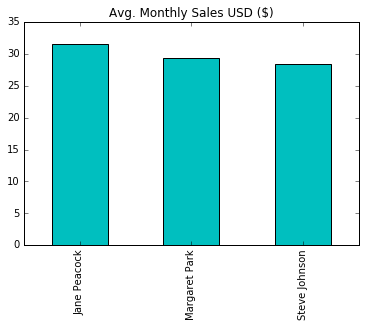

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
df = pd.DataFrame(columns=['Avg. Monthly Sales'], 
                  index=['Jane Peacock', 'Margaret Park', 'Steve Johnson'],
                  data=[1731.51/55, 1584/54, 1393.92/49])
df.plot(kind='bar', color='c', legend=False, title='Avg. Monthly Sales USD ($)')
plt.show()

###### Q2 Discussion:
- At a glance, Jane appears to be the best salesperson, with Margaret and Steve following in second and third respectively.
- One might assume that their earlier hire date would be the reason for this, however taking a look at the avg. monthly figures, the salespeople still rank in the same order with Jane coming out on top.

---

### Q3. Top Countries 

Next up, let's analyze the sales data for customers from each different country. 

**Query aims**: Calculate for each country the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value
- note: countries with just one customer should be collected under 'Other'

In [8]:
%%sql
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        COUNT(distinct customer_id) customers,
        ROUND(SUM(unit_price), 5) total_sales,
        ROUND(SUM(unit_price) / COUNT(DISTINCT customer_id), 4) customer_lifetime_value,
        ROUND(SUM(unit_price) / COUNT(DISTINCT invoice_id), 4) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.49,7.9427,80.0377
Canada,8,535.59,7.0472,66.9488
Brazil,5,427.68,7.0111,85.536
France,5,389.07,7.7814,77.814
Germany,4,334.62,8.1615,83.655
Czech Republic,2,273.24,9.108,136.62
United Kingdom,3,245.52,8.7686,81.84
Portugal,2,185.13,6.3838,92.565
India,2,183.15,8.7214,91.575
Other,15,1094.94,7.4486,72.996


###### Q3 Discussion:
- USA is clearly the top market for Chinook and it should be a focus to keep abreast of the music trends there.
- Other top focus countries include Canada and Brazil.
- Brazil in particular has a higher average customer value than the US. It could be worth focusing on these key 'loyal customers' to drive even more revenue. 
- One possibility could be to introduce language support and even songs in other languages:
    - for Brazil that would be Portuguese.
    - investigate if there is a market for French songs in Canada.
    - if so that would also be good for the France market which is 4th for total sales
    - Germany also has a high average customer value given 4 customers & CZ in particular has the highest avg (though with just 2 loyal customers).

---

### Q4. How many Album Purchases (v.s. Individually Selected Songs)?

**Context**: Chinook's store is setup such that customers can purchase in one of the two ways:

1. purchase a whole album
2. purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

With all of this in mind, let's try to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

**Query aims**:
- Categorize each invoice as either an album purchase or not, and calculate the following summary statistics:
    - Number of invoices
    - Percentage of invoices
- From that, make a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies.

In [22]:
%%sql
WITH invoice_album AS   
                    (
                     SELECT i.invoice_id,                                     
                            t.album_id
                       FROM invoice_line i
                       LEFT JOIN track t ON t.track_id = i.track_id
                      GROUP BY 1
                    ),

     album_or_tracks AS 
                        (
                              SELECT ia.*,
                                CASE
                                WHEN 
                                     (
                                      SELECT il.track_id 
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id
                                      EXCEPT                                          
                                      SELECT t.track_id 
                                        FROM track t
                                       WHERE t.album_id = ia.album_id) IS NULL
                             
                                 AND 
                                     (
                                      SELECT t.track_id 
                                        FROM track t
                                       WHERE t.album_id = ia.album_id                                         
                                      EXCEPT                                          
                                      SELECT il.track_id 
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id
                                     ) IS NULL
                                   
                                THEN "Album"
                                ELSE "Tracks"
                                END AS purchase_type                             
                           FROM invoice_album ia
                        )
                           
SELECT purchase_type,
       COUNT(*) AS num_invoices,
       ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*)
                                  FROM invoice), 1) AS "%"
  FROM album_or_tracks
 GROUP BY 1
 ORDER BY 2 DESC;

Done.


purchase_type,num_invoices,%
Tracks,500,81.4
Album,114,18.6


###### Q4 Discussion:
- Here, purchases consisting of purely an album purchase make up less than 19% of sales.
- Thus, the business's idea of moving to a new model of purchasing individual songs rather than entire albums could be a good idea.
- The recommendation would be to start trialing this idea with the less popular artists and albums before making major changes to the store structure.
    - E.g. for extremely popular artists like Guns n Roses, Queen, Nirvana, Red Hot Chili Peppers etc., entire album sales are presumably quite common.
    - Whereas for smaller artists and "one-hit-wonders", it might make more sense to only list the singles and popular songs, as people might not be so quick to buy full albums.

---

### This concludes this set of business questions for now...

However, some other business questions to propose and explore further could be:
- Continuing the above train of thought, conduct a deeper dive to see if it's the case that the popular artists bring in more album sales (or not)?
- Which artists are featured in the most playlists?
- How many individual tracks have been purchased vs not purchased at all?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?